# Sandbox

## Step 1 : Import librairies

In [1]:
import random
import pandas as pd
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
# to install pytorch, follow instructions on https://pytorch.org/get-started/locally/
# if CUDA is installed, this should allow GPU training
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from PIL import Image
import torch.optim as optim
# -> pip install torchsummary
from torchsummary import summary
print(torch.cuda.is_available())

True


## Step 2 : Retrieve data

In [2]:
TABLENAME = "Train_Crash_Table.csv"

df = pd.read_csv(TABLENAME)

df

,subject,collision
0,00001.jpg,0
1,00002.jpg,0
2,00003.jpg,0
3,00004.jpg,0
4,00005.jpg,0
...,...,...
9995,09996.jpg,0
9996,09997.jpg,0
9997,09998.jpg,0
9998,09999.jpg,1


In [3]:
# Select only the frame columns from the DataFrame
frame_data = df["collision"]

# Flatten data into a single list
y = frame_data.values.flatten()

print(y)
print(y.shape)

[0 0 0 ... 0 1 0]
(10000,)


Image width: 256, Image height: 256


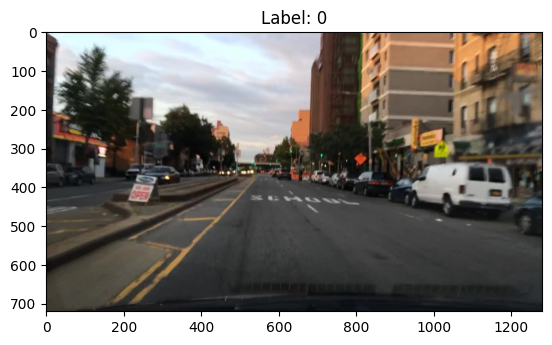

In [ ]:
import cv2
import numpy as np
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib.widgets import Button
import matplotlib.pyplot as plt
import keyboard
import time

IMAGE_PATH = "C:\\Users\\sacha\\OneDrive\\Bureau\\dataset"
BATCH_SIZE = int(len(y))

image_paths = list(Path(IMAGE_PATH).glob("*.jpg"))[:BATCH_SIZE]
img_width = 256
img_height = 256

# Create a matplotlib figure and axis
fig, ax = plt.subplots()

# Initialize index to track the current image
current_index = 0

def update_image():
    """Update the displayed image and label."""
    global current_index
    image_path = image_paths[current_index]
    image = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
    ax.clear()
    ax.imshow(image)
    ax.set_title(f"Label: {y[current_index]}")
    fig.canvas.draw()

def on_key(event):
    """Handle key press events."""
    global current_index
    key = cv2.waitKey(0) & 0xFF  # Wait for a key press and get the key code
    print(f"Key pressed: {key}")
    if key == ord('\x1b[C'):  
        current_index = (current_index + 1) % len(image_paths)
        update_image()
    elif key == ord('\x1b[D'):  
        y[current_index] = 1 - y[current_index]  # Flip 0 to 1 or 1 to 0
        update_image()
        


while True:
    if keyboard.is_pressed("left"):
        print("gauche")
        time.sleep(0.3)  # Prevent multiple prints for a single press
    elif keyboard.is_pressed("right"):  # Move to the next image (Right Arrow Key)
        print("droite")
        time.sleep(0.3)
    elif keyboard.is_pressed("esc"):    # Toggle the label (Left Arrow Key)
        print("Sortie...")
        break
    time.sleep(0.05)

gauche
droite
gauche
droite
gauche
droite
droite
droite
droite
droite
droite
droite
gauche
gauche
gauche
gauche
Sortie...


In [ ]:
class LazyCrashFrameDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (img_width, img_height))
        label = self.labels[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.transform:
            image = self.transform(image)
        return image, label

# Use the existing transform variable defined in a previous cell
dataset = LazyCrashFrameDataset(image_paths, y)

In [ ]:
index = random.randint(0, len(X))-1

plt.imshow(X[index])
print(y[index])

In [ ]:
def process_image(index, image_path):
    image = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (img_width, img_height))
    return index, image

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image, i, path) for i, path in enumerate(image_paths)]
    
    for count, future in enumerate(as_completed(futures), start=1):
        i, image = future.result()
        X[i] = image
        print(f"Processing {image_paths[i].name}: {100 * (count / BATCH_SIZE):.2f}% completed")

X = np.asarray(X)
print("Final shape:", X.shape)

class CrashFrameDataset(Dataset):
    def __init__(self, image, labels, transform=None):
        self.images = image
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = Image.fromarray(self.images[idx].astype('uint8'))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # pour des images RGB
])

# Step 3: Preparing the Data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y[:BATCH_SIZE], test_size=0.33, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
dataset = CrashFrameDataset(X_train, y_train, transform=transform)

# Create a DataLoader for the dataset
loader = DataLoader(dataset, batch_size=5, shuffle=True)

# Step 4: Build a Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrashDetection(nn.Module):
    def __init__(self, input_channels=3, filter_base=8, input_height=256, input_width=256):
        super(CrashDetection, self).__init__()
        self.input_channels = input_channels
        self.filter_base = filter_base
        self.input_height = input_height
        self.input_width = input_width

        # CNN layers
        self.conv1_1 = nn.Conv2d(input_channels, filter_base, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(filter_base, filter_base, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=4)

        self.conv2_1 = nn.Conv2d(filter_base, filter_base * 2, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(filter_base * 2, filter_base * 2, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=4)

        self.conv3_1 = nn.Conv2d(filter_base * 2, filter_base * 4, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(filter_base * 4, filter_base * 4, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Placeholder for output size
        self._to_linear = None
        self._compute_flattened_size()

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 16)
        self.fc3 = nn.Linear(16, 1)

    def _compute_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, self.input_channels, self.input_height, self.input_width)
            x = F.relu(self.conv1_1(x))
            x = F.relu(self.conv1_2(x))
            x = self.pool1(x)

            x = F.relu(self.conv2_1(x))
            x = F.relu(self.conv2_2(x))
            x = self.pool2(x)

            x = F.relu(self.conv3_1(x))
            x = F.relu(self.conv3_2(x))
            x = self.pool3(x)

            self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        #print('Output shape of layer 1', x.shape)

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        #print('Output shape of layer 2', x.shape)

        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool3(x)
        #print('Output shape of layer 3', x.shape)

        x = x.reshape(x.size(0), -1)
        #print('Shape required to pass to Linear Layer', x.shape)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CrashDetection(input_channels=3, filter_base=8, input_height=img_height, input_width=img_width).to(device)
summary(model, (3, img_width, img_height))

In [ ]:
# test with one batch, to see if the model works. enable the prints in the forward pass for size matching.
# Get one batch of images from the dataloader
images, labels = next(iter(loader))

# Move the images to the device (GPU/CPU)
images = images.to(device)

# Pass the batch of images through the model
outputs = model.forward(images)

# Print the output shape
print("Output shape:", outputs.shape)

# Update the loss function to match the binary classification task
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss with logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Step 5: Train the model

In [ ]:
%%time

batch_size = 50
epochs = 6

# Recreate the dataloader with new batch size
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

loss_history = []
accuracy_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_accuracy = 100 * correct / total

    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

In [ ]:
print(f"Number of samples in the dataset: {len(loader.dataset)}")

In [ ]:
fig, ax1 = plt.subplots()

# Plot loss on the primary y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(loss_history, label='Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:orange')
ax2.plot(accuracy_history, label='Accuracy', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add a title and show the plot
plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()

# Step 6 : Evaluation 

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# parameters for test set
BATCH_SIZE = 10

# dataset for test set and avoids crashes when loading images
class TestImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype('float32') / 255.0  # normalisation
        image = torch.tensor(image).permute(2, 0, 1)  # HWC → CHW
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# DataLoader for test set
test_dataset = TestImageDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# evaluate the model on the test set
model.eval()
all_preds = []
all_targets = []
total_loss = 0.0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())  # Convert labels to float and reshape to match outputs

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

        total_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)


avg_loss = total_loss / total_samples
accuracy = accuracy_score(all_targets, all_preds)

print(f"Test loss     : {avg_loss:.4f}")
print(f"Test accuracy : {accuracy:.4f}")
print(classification_report(all_targets, all_preds, digits=4))

In [ ]:
#Create confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(cm.shape[0]),
            yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 7 : Save the model

In [ ]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(model.state_dict(), f"CarCrashTensorflow_{timestamp}.keras")


# Step 8 : Load and try the model with new data

In [ ]:
model_path = "CarCrashPytorch_20250421_232547.keras"  # Replace with your actual path

model2 = CrashDetection().to(device)
model2.load_state_dict(torch.load(model_path))
model2.eval()  # Set the model to evaluation mode

In [ ]:
NewData = cv2.cvtColor(cv2.imread('NewCrash.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(NewData)

In [ ]:
NewData = cv2.resize(NewData,(256,256))
plt.imshow(NewData)

In [ ]:
NewData.shape

In [ ]:
# Preprocess the NewData
if NewData.ndim == 3:  # Check if NewData is missing the batch dimension
    NewData = np.expand_dims(NewData, axis=0)  # Add batch dimension

NewData_tensor = torch.tensor(NewData, dtype=torch.float32).permute(0, 3, 1, 2).to(device) / 255.0  # Normalize to [0, 1]

# Set the model to evaluation mode
model2.eval()

# Perform prediction
with torch.no_grad():
    y_sigmoid = model2(NewData_tensor)
    y_pred = torch.argmax(y_sigmoid, axis=-1).cpu().numpy()


if y_pred == 0:
    print(f"No crash detected") 
else:
    print(f"Crash detected ")